# Prosumer Problem Experiments


In [1]:
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import numpy as np
from matplotlib import pyplot as plt
from dimod import RandomSampler, SampleSet, BinaryQuadraticModel

from evaluation import RESULTS, ResultStorage
from instances import InstanceManager
# from qaoa_pipeline.ir import PassManager
# from benchmarking.instance_manager import InstanceManager
# import warnings

sns.set_theme(style="whitegrid", palette="colorblind")

### Data Loading and Pre-Processing

In [2]:
er = ResultStorage(RESULTS / "bra_red_0303.csv")
im = InstanceManager("../instances/prosumer_problem/")

Loading '/Users/david/work/q-grid/mulit-constrained-qaoa-data/notebooks/../results/bra_red_0303.csv'... 
Done 2544


In [3]:
# load results
df = er.get_df(
    "layer",
    "rel_energy_error",
    "tts",
    "p_opt",
    "feasibility_ratio",
    "opt_params",
    "statevector_size",
    "n_qubits",
)

# group instance naming
df["kind"] = df["id"].transform(lambda x: "_".join(x.split("_")[:2]))

# fix search spaces
def f(x):
    final_copied = np.array(x.statevector_size)
    if "oneh" in x.pipeline_name.unique():
        sv = x.query("pipeline_name == 'oneh'").iloc[0].statevector_size
        final_copied[final_copied == sv] = x.query("pipeline_name == 'i2i+oneh'").iloc[0].statevector_size
    if "default" in x.pipeline_name.unique():
        sv = x.query("pipeline_name == 'default'").iloc[0].statevector_size
        final_copied[final_copied == sv] = x.query("pipeline_name == 'i2i'").iloc[0].statevector_size
    return pd.Series(final_copied, index=x.index)
df["search_space"] = df.groupby("id", group_keys=False).apply(f, include_groups=False)

# rename pipelines
pipeline_namer = {"default": "QUBO", "i2i": "IF", "oneh": "XY", "i2i+oneh": "IF+XY"}
df["method"] = df.pipeline_name.map(pipeline_namer)

# exctract number of binary variables
df["binary_variables"] = df.id.transform(lambda x: im.get(x)[0].num_variables())

# define markers
markers = {"default": "o", "oneh": "s", "i2i": "d", "i2i+oneh": "X"}
Markers = {"QUBO": "o", "XY": "s", "IF": "d", "IF+XY": "X"}

### Initial Plots

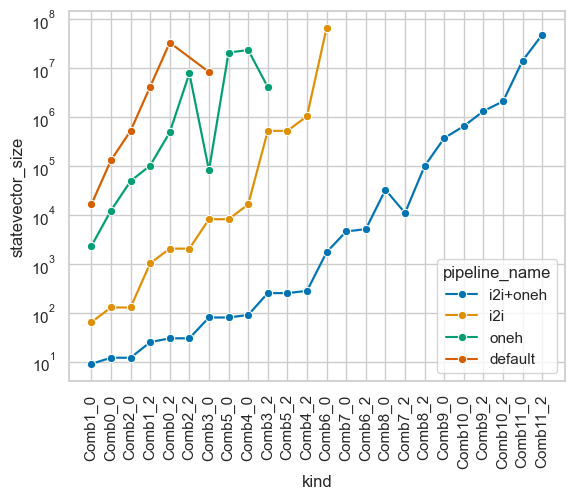

In [4]:
sns.lineplot(
    df[df["layer"] == 1]
    .sort_values(["binary_variables", "id"])
    .reset_index(),
    x="kind",
    y="statevector_size",
    hue="pipeline_name",
    marker="o",
)
plt.yscale("log")
plt.xticks(rotation=90, ha="center", va="top");

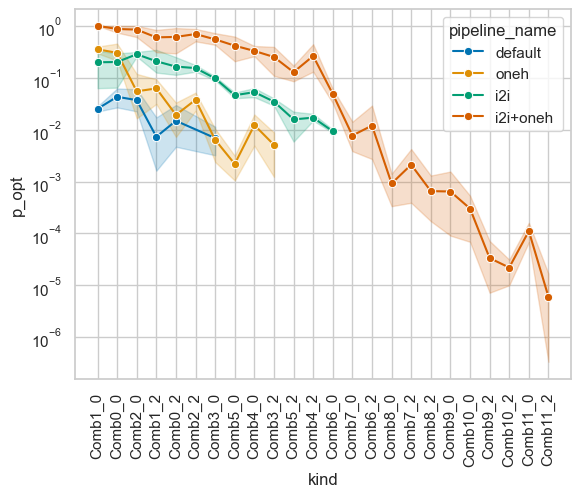

In [5]:
# plot p_opt
sns.lineplot(
    df[df["layer"] == 12]
    .sort_values(["binary_variables", "id"])
    .reset_index(),
    x="kind",
    y="p_opt",
    hue="pipeline_name",
    hue_order=["default", "oneh", "i2i", "i2i+oneh"],
    marker="o",
)
# plt.yscale("log")
plt.xticks(rotation=90, ha="center", va="top");
plt.yscale("log")

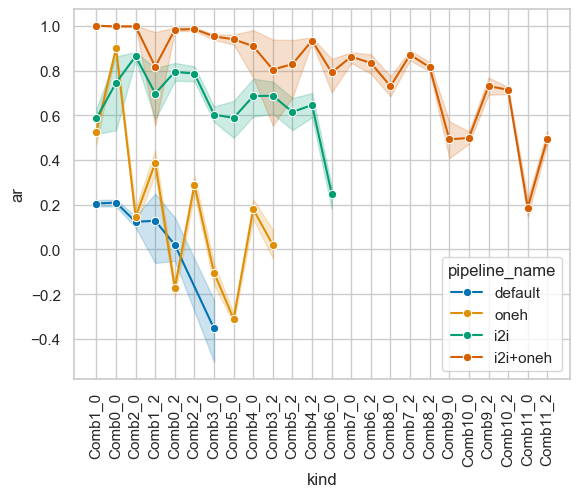

In [6]:
# plot approximation ratio
df["ar"] = 1 - df["rel_energy_error"]


sns.lineplot(
    df[df["layer"] == 12]
   .sort_values(["binary_variables", "id"])
    .reset_index(),
    x="kind",
    y="ar",
    hue="pipeline_name",
    hue_order=["default", "oneh", "i2i", "i2i+oneh"],
    marker="o",
)
# plt.yscale("log")
plt.xticks(rotation=90, ha="center", va="top");

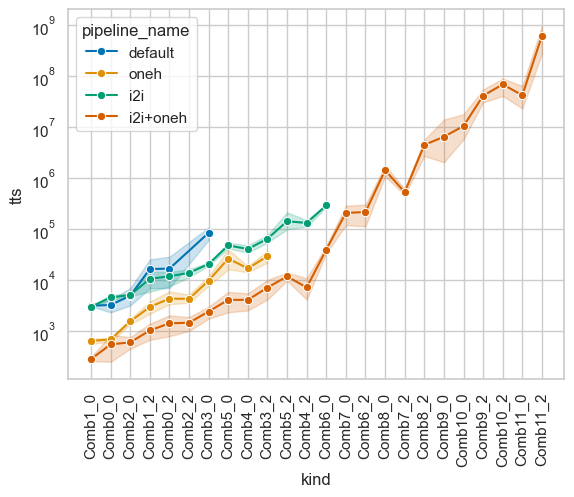

In [7]:
# Extract rows with optimal TTS
def find_min_tts(x):
    idx = x.tts.argmin()
    s = x.iloc[idx]
    return s

dfx = (
    df.groupby(["pipeline_name", "id"], group_keys=False)
    .apply(find_min_tts, include_groups=False)
    .reset_index()
)

sns.lineplot(
    dfx
    .sort_values(["binary_variables", "id"])
    .reset_index(),
    x="kind",
    y="tts",
    hue="pipeline_name",
    hue_order=["default", "oneh", "i2i", "i2i+oneh"],
    marker="o",
)
plt.yscale("log")
plt.xticks(rotation=90, ha="center", va="top");

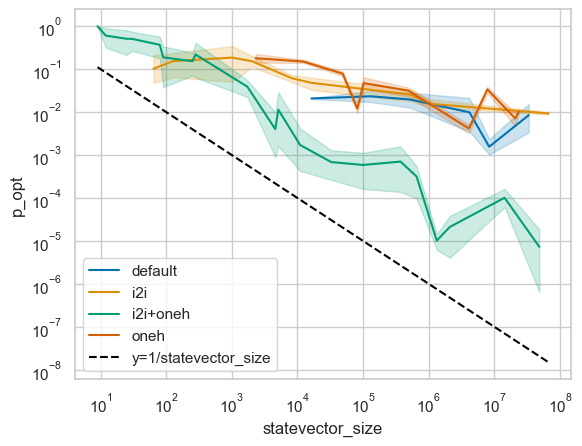

In [8]:
sns.lineplot(
    dfx.sort_values(["pipeline_name"]), x="statevector_size", y="p_opt", hue="pipeline_name"
)
plt.yscale("log")
plt.xscale("log")
x_vals = dfx["statevector_size"].sort_values().unique()
y_vals = 1 / x_vals
plt.plot(x_vals, y_vals, label="y=1/statevector_size", linestyle="--", color="black")

plt.legend()

plt.show()

### TTS Scaling Plot

Text(0, 0.5, 'TTS* [circuit layer]')

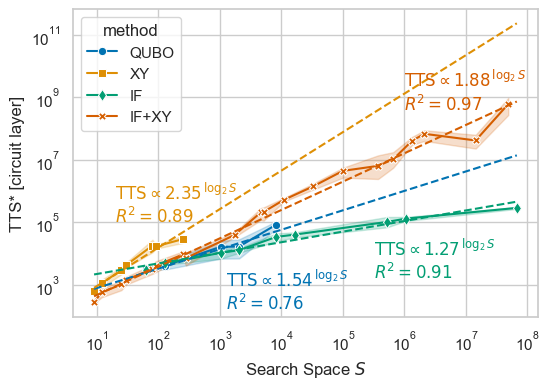

In [9]:
# Extrapolation Plot
palette = sns.color_palette("colorblind", n_colors=df["pipeline_name"].nunique())
plt.subplots(figsize=(6, 4))

pipeline_order = ["QUBO", "XY", "IF", "IF+XY"]

# plot baseline data
p = sns.lineplot(
    data=dfx.sort_values(["pipeline_name"]),
    x="search_space",
    y="tts",
    hue="method",
    style="method",
    # palette=palette,
    hue_order=pipeline_order,
    markers=Markers,
    dashes=False,
)
sns.move_legend(p, loc="upper left", title="method")
plt.yscale("log")
plt.xscale("log")


# label positions
pos = {
    "IF": (10**5.5, 10**3.2),
    "QUBO": (10**3.1, 10**2.2),
    "IF+XY": (10**6, 10**8.6),
    "XY": (10**1.3, 10**5),
}

# fit regression lines
models = {}
for i, name in enumerate(pipeline_order):
    group = dfx.query("method == @name")
    x = np.log2(group["search_space"])
    y = np.log2(group["tts"])

    model = sm.OLS(y, sm.add_constant(x)).fit()

    x_pred = np.log2(
        np.array([dfx["search_space"].min(), dfx["search_space"].max()])
    )
    y_pred = model.predict(sm.add_constant(x_pred))

    models[name] = model

    sv = model.params["search_space"]
    r2 = model.rsquared

    s = (
        r"$\mathrm{TTS} \propto "
        + f"{(2 ** sv):.2f}"
        + r"^{\,\log_2 S}$"
        + "\n"
        + "$R^2 = "
        + f"{r2:.2f}"
        + "$"
    )
    plt.text(*pos[name], s=s, color=palette[i])

    plt.plot(
        np.exp2(x_pred),
        np.exp2(y_pred),
        label=f"{name} (fit)",
        linestyle="--",
        color=palette[i],
    )


plt.xlabel("Search Space $S$")
plt.ylabel("TTS* [circuit layer]")

# plt.savefig("plots/search_space_tts_relation.pdf", bbox_inches="tight")

### RAAR, $P^*$ and extrapolated TTS plot

In [10]:
# get random energies from 10000k samples for RAAR
rnd_sampler = RandomSampler()
def rnd_energy(cqm, best):
    bqm = BinaryQuadraticModel(cqm.objective.linear, cqm.objective.quadratic, vartype="BINARY")
    x = rnd_sampler.sample(bqm, num_reads=10000, seed=int(best))
    sset = SampleSet.from_samples_cqm(x.samples(sorted_by=None), cqm)
    sset.record.energy += best * np.sum(np.logical_not(sset.record.is_satisfied), axis=1)
    return sset.record.energy.mean()


def raar(rel_energy_error, best, rnd):
    energy = (1 + rel_energy_error) * best
    return (rnd - energy) / (rnd - best)


rnd_energies = {}

for cqm, best, name in im.instance_iterator():
    rnd_energies[name] = rnd_energy(cqm, best)

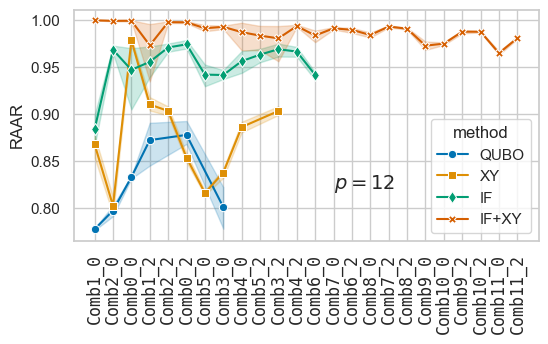

In [11]:

plt.subplots(figsize=(6, 3))

df["raar"] = df.apply(lambda x: raar(x.rel_energy_error, im.get(x.id)[1], rnd_energies[x.id]), axis=1)

sns.lineplot(
    df[df["layer"] == 12]
    .sort_values(["binary_variables"])
    .reset_index(),
    x="kind",
    y="raar",
    hue="method",
    style="method",
    dashes=False,
    hue_order=["QUBO", "XY", "IF", "IF+XY"],
    markers=Markers,
)
plt.xticks(rotation=90, ha="center", va="top", font="monospace");

plt.ylabel("RAAR")
plt.xlabel("")

plt.text(x=13, y=0.82, s="$p=12$", fontsize=14)
plt.legend(title="method")

# plt.savefig("plots/raar.pdf", bbox_inches="tight")

In [12]:
# load data containing statevector and search space info for up until Comb11_2
df2 = pd.read_csv(RESULTS / "pp_extrapolation.csv", index_col=0)

# extrapolate using fitted models from above
def extrapolate_tts(row):
    x = [[1, np.log2(row.search_space)]]
    log_tts = models[row.method].predict(x)[0]
    expected_tts = np.exp2(log_tts)
    return pd.Series({"expected_tts": expected_tts, "log_tts": log_tts})


z = df2.apply(extrapolate_tts, axis=1)
df2 = df2.join(z, how="outer")

(1e-07, 2)

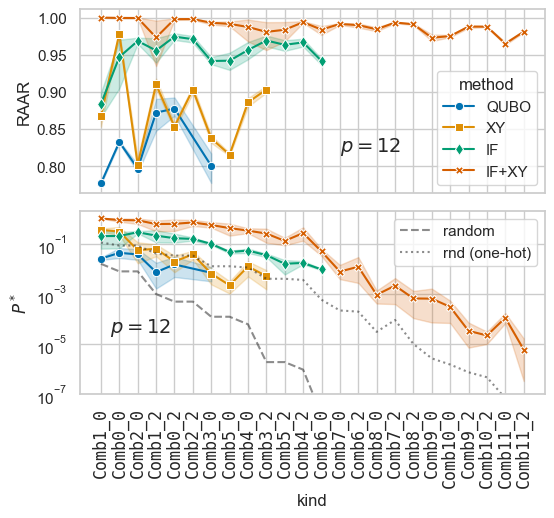

In [13]:
fig, axs = plt.subplots(2, 1, figsize=(6, 5), sharex=True)

df["raar"] = df.apply(lambda x: raar(x.rel_energy_error, im.get(x.id)[1], rnd_energies[x.id]), axis=1)

dfx = df[df["layer"] == 12].sort_values(["binary_variables", "id"]).reset_index()

df2["p_opt_random"] = 1 / df2.sv_size

sns.lineplot(
    dfx,
    x="kind",
    y="raar",
    hue="method",
    hue_order=["QUBO", "XY", "IF", "IF+XY"],
    style="method",
    markers=Markers,
    dashes=False,
    ax=axs[0]
)

sns.lineplot(
    dfx,
    x="kind",
    y="p_opt",
    hue="method",
    style="method",
    hue_order=["QUBO", "XY", "IF", "IF+XY"],
    markers=Markers,
    dashes=False,
    legend=False,
    ax=axs[1]
)
# plt.yscale("log")
plt.xticks(rotation=90, ha="center", va="top", font="monospace");
plt.yscale("log")

axs[0].set_ylabel("RAAR")
plt.ylabel("$P^*$")
plt.xlabel("")

axs[0].text(x=13, y=0.82, s="$p=12$", fontsize=14)

# plt.text(x=7, y=3e-6, s="$p=12$", fontsize=14)
plt.text(x=0.5, y=30e-6, s="$p=12$", fontsize=14)
axs[0].legend(title="method")

fig.subplots_adjust(hspace=0.1)

# sns.lineplot(df2.query("method == 'IF+XY'"), x="kind", y="p_opt_random", ax=axs[1], color="k")
sns.lineplot(df2.query("method == 'IF'"), x="kind", y="p_opt_random", ax=axs[1], color="k", alpha=0.5, linestyle="dashed", label="random", errorbar=None)
sns.lineplot(df2.query("method == 'IF+XY'"), x="kind", y="p_opt_random", ax=axs[1], color="k", alpha=0.5, linestyle="dotted", label="rnd (one-hot)", errorbar=None)


plt.ylim(10**-7, 2)
# plt.savefig("plots/raar_popt.pdf", bbox_inches="tight")

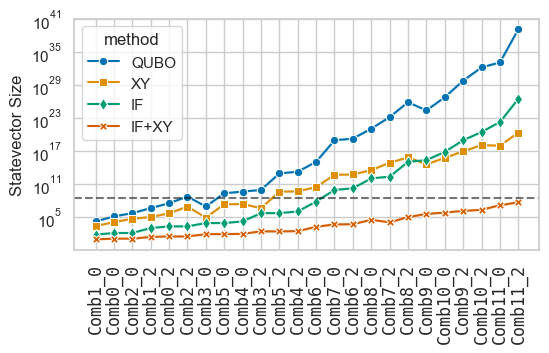

In [14]:
# Plot the state vector sizes required for simulation
plt.subplots(figsize=(6, 3))

p = sns.lineplot(
    df2.sort_values(["binary_variables", "id"]),
    x="kind",
    y="sv_size",
    hue="method",
    style="method",
    markers=Markers,
    dashes=False,
    hue_order=pipeline_order,
)
plt.yscale("log")
plt.xticks(rotation=90, ha="center", va="top", font="monospace");
plt.axhline(2**28, color="k", linestyle="dashed", alpha=0.6)

plt.ylabel("Statevector Size")
plt.xlabel("")
sns.move_legend(p, loc="upper left", title="method")

# plt.savefig("plots/sv_size.pdf", bbox_inches="tight")

(np.float64(37.012303820334814), 1000000000000)

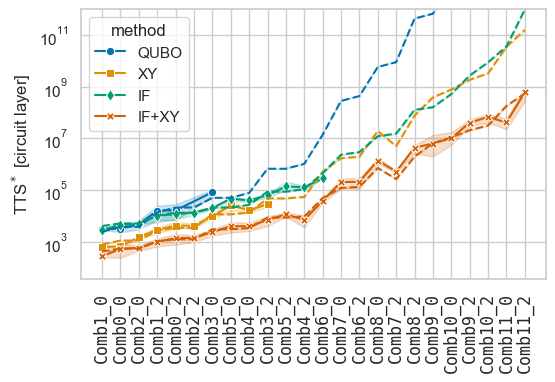

In [15]:
# Plot the TTS with extrapolation
plt.subplots(figsize=(6, 3.5))

dfx = (
    df.groupby(["pipeline_name", "id"], group_keys=False)
    .apply(find_min_tts, include_groups=False)
    .reset_index()
)

p = sns.lineplot(
    dfx.sort_values(["binary_variables", "id"]),
    x="kind",
    y="tts",
    hue="method",
    style="method",
    dashes=False,
    markers=Markers,
    hue_order=pipeline_order,
)
sns.lineplot(
    df2.sort_values(["binary_variables", "id"]),
    x="kind",
    y="expected_tts",
    hue="method",
    linestyle="dashed",
    legend=False,
    hue_order=pipeline_order,
)
plt.yscale("log")
plt.xticks(rotation=90, ha="center", va="top", font="monospace")

plt.ylabel("TTS$^*$ [circuit layer]")
plt.xlabel("")
sns.move_legend(p, loc="upper left", title="method")

plt.ylim(None, 10**12)

# plt.savefig("plots/tts_result_with_extrapolation.pdf", bbox_inches="tight")